# Multiclass Semantic Segmentation using WeedMap dataset and SegNet Network

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
import cv2
from pathlib import Path
import pathlib
from PIL import Image
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from pylab import *

from tqdm import tqdm
from tqdm import tqdm_gui
import segmentation_models as sm
sm.set_framework('tf.keras')
#from DATASETS.RedEdge.io_class import HDF5DatasetGenerator
from PREPROCESSING.aspectawarepreprocessor import AspectAwarePreprocessor
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


# Environment checks

In [2]:
print(tf.__version__)

2.0.0


In [3]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [4]:
print(tf.executing_eagerly())

True


## Extract Target Class definitions

### Function to parse the file "label_colors.txt" which contains the class definitions

In [5]:
IMG_DIR = Path.home() / Path(r"WeedMapSemanticSegmentation/DATASETS/RedEdge/")

def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

### Parse and extract label names and codes

In [6]:
label_codes, label_names = zip(*[parse_code(l) for l in open(str(IMG_DIR / "label_colors.txt"))])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:], label_names[:]

([(0, 0, 0), (255, 0, 0), (0, 255, 0)], ['Background', 'weed', 'crop'])

In [7]:
label_codes, label_names

([(0, 0, 0), (255, 0, 0), (0, 255, 0)], ['Background', 'weed', 'crop'])

### Create useful label and code conversion dictionaries
_These will be used for:_
- One hot encoding the mask labels for model training
- Decoding the predicted labels for interpretation and visualization

In [8]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [9]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [10]:
id2code

{0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 255, 0)}

In [11]:
id2name

{0: 'Background', 1: 'weed', 2: 'crop'}

### Define functions for one hot encoding rgb labels, and decoding encoded predictions

In [12]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: v
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [13]:
import numpy as np
import h5py

class HDF5DatasetGenerator:
    def __init__(self, dbPath, batchSize, preprocessors=None, aug=None, classes=3, encoded=True):
        # store the batch size, preprocessors, and data augmentor,
        # along with the total number of classes
        self.batchSize = batchSize
        self.preprocessors = preprocessors
        self.aug = aug
        self.classes = classes
        self.encoded = encoded
        # Open the HDF5 dataset for reading and determnine the total
        # number of entries in the database
        self.db = h5py.File(dbPath, "r")
        self.numImages = self.db["labels"].shape[0]
        print("[INFO] The number of images is: {}".format(self.numImages))
        
    def generator(self, passes=np.inf):
        # intialize the epoch count
        epochs = 0

        # keep looping infinitely -- the mode will stop once we have
        # to reach the disered number of epochs
        while epochs < passes:
            # loop over the HDF5 dataset
            for i in range(0, self.numImages, self.batchSize):
                # extract the images and labels
                images = self.db["images"][i: i + self.batchSize]
                masks = self.db["labels"][i: i + self.batchSize]
                
                # check to see if our preprocessors are not None
                if self.preprocessors is not None:
                    # initialize the list of pocessed images
                    procImages = list()
                    procMasks = list()
                    
                    # loop over the image
                    for i in range(len(images)):
                        image = images[i]
                        mask = masks[i]
                        # loop over the preprocessors and apply each
                        # to the image/mask
                        for p in self.preprocessors:
                            image = p.preprocess(image)
                            mask = p.preprocess(mask)
                        # update the list of processed images/masks
                        if (len(image.shape) < 3):
                            procImages.append(np.expand_dims(image, axis=-1))
                        else:
                            procImages.append(image)
                        
                        if (len(mask.shape) < 3):
                            procMasks.append(np.expand_dims(mask, axis=-1))
                        else: 
                            procMasks.append(mask)
                    
                    # update the images/masks arrays to be the processed
                    # images
                    images = np.asarray(procImages)
                    masks = np.asarray(procMasks)
                 
                # if the data augmentator exists, apply it
                if self.aug is not None:
                    (images, masks) = next(self.aug.flow(
                            images, masks, batch_size=self.batchSize))  
                # yield a tuple of images and masks
                if self.encoded:
                    mask_encoded = [rgb_to_onehot(masks[x,:,:,:], id2code) for x in range(masks.shape[0])]
                    yield images, np.asarray(mask_encoded)
                else:
                    yield images, masks
                
                
            epochs +=1

    def close(self):
        # close the database
        self.db.close()

In [14]:
# construct the training image generator for data augmentation
IMG_DIR =  Path.home() / Path(r"WeedMapSemanticSegmentation/DATASETS/RedEdge")
TRAIN_HDF5 = Path.home() / Path(r"WeedMapSemanticSegmentation/DATASETS/RedEdge/EXP4_RGB_BS5/train.hdf5")
VAL_HDF5 = Path.home() / Path(r"WeedMapSemanticSegmentation/DATASETS/RedEdge/EXP4_RGB_BS5/val.hdf5")


aug = ImageDataGenerator(rescale=1./255, fill_mode="nearest")
awp = AspectAwarePreprocessor(224, 224)

# initialize the training and validation dataset generators
trainGen_test = HDF5DatasetGenerator(TRAIN_HDF5, 5, aug=aug, preprocessors=[awp], classes=3, encoded=False)
#valGen_test = HDF5DatasetGenerator(VAL_HDF5, 5, aug=aug, preprocessors=[awp], classes=3, encoded=False)
#trainGen = HDF5DatasetGenerator(TRAIN_HDF5, 5, aug=None, preprocessors=None, classes=3)
#valGen = HDF5DatasetGenerator(VAL_HDF5, 5, aug=None, preprocessors=None, classes=3)
# test the generator
image_test, mask_test = next(trainGen_test.generator())

[INFO] The number of images is: 613


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


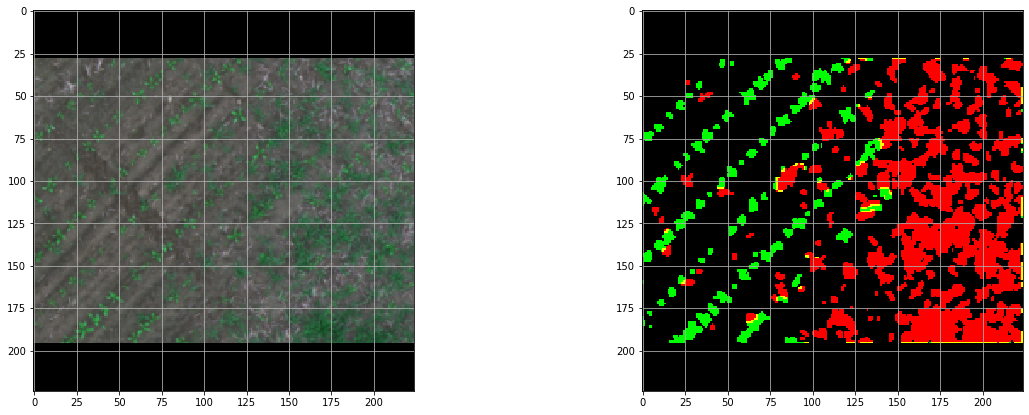

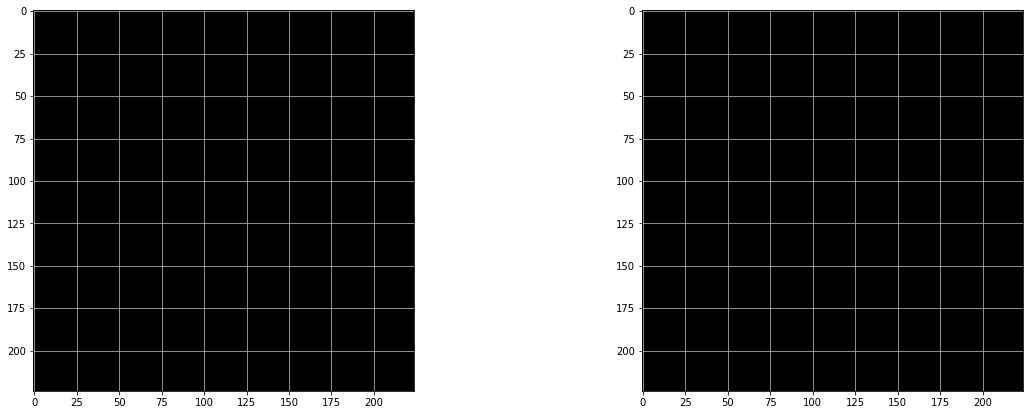

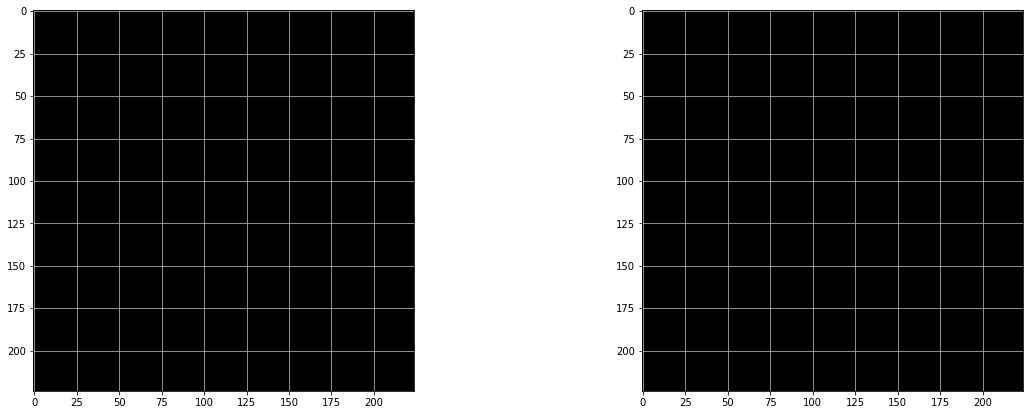

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


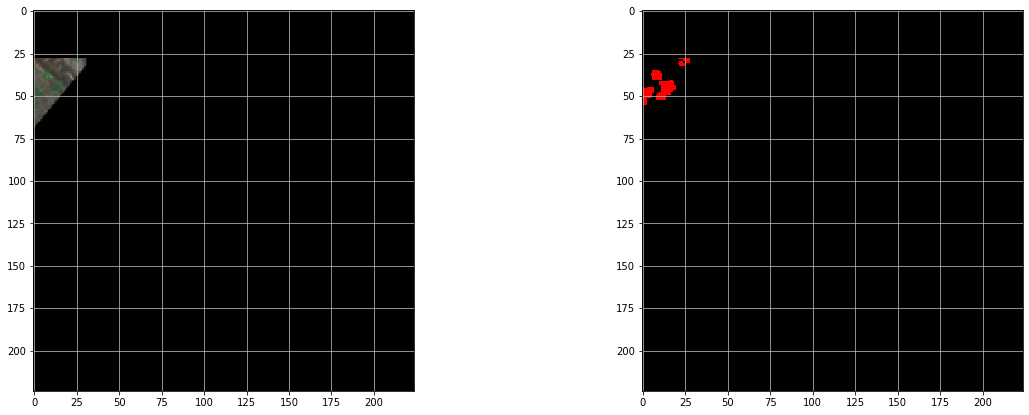

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


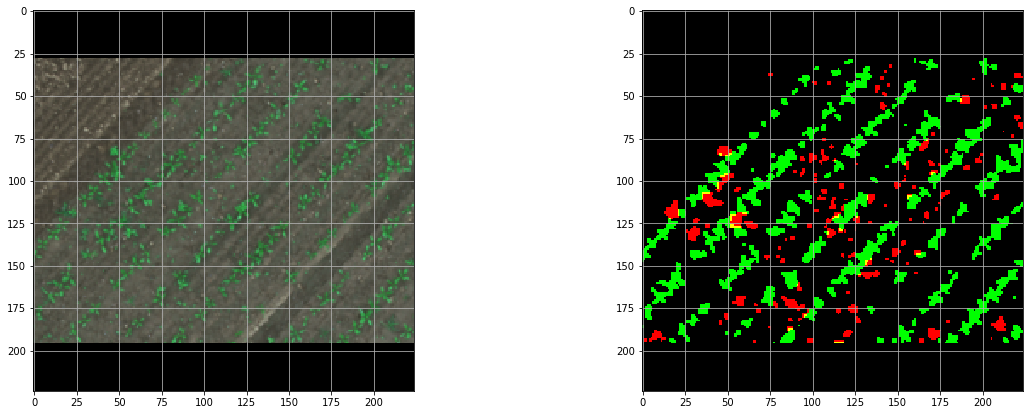

In [15]:
n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    frame = image_test[i]
    mask = mask_test[i]
    
    #Plot the corresponding frames and masks
    fig = plt.figure(figsize=(20,7))
    fig.add_subplot(1,2,1)
    plt.grid(b=None)
    plt.imshow(np.squeeze(frame))
    fig.add_subplot(1,2,2)
    plt.grid(b=None)
    plt.imshow(mask)
    plt.show()

In [26]:
trainGen = HDF5DatasetGenerator(TRAIN_HDF5, 5, aug=aug, preprocessors=[awp], classes=3)
valGen = HDF5DatasetGenerator(VAL_HDF5, 5, aug=aug, preprocessors=[awp], classes=3)

[INFO] The number of images is: 613
[INFO] The number of images is: 153


# Defining VGG-16 SegNet model for semantic segmentation

<div style="text-align: center;">
        
![alt text](https://www.researchgate.net/profile/Vijay_Badrinarayanan/publication/283471087/figure/fig1/AS:391733042008065@1470407843299/An-illustration-of-the-SegNet-architecture-There-are-no-fully-connected-layers-and-hence.png)

[Picture Credits]https://www.researchgate.net/profile/Vijay_Badrinarayanan/publication/283471087/figure/fig1/AS:391733042008065@1470407843299/An-illustration-of-the-SegNet-architecture-There-are-no-fully-connected-layers-and-hence.png)<br><br>

### Function SegNet model using VGG-16 pretrained

In [27]:
def CUSTOM_VGG16_SEGNET(num_classes, input_height, input_width, input_depth, vgg_level=-1):
    VGG_Weights_path = "/home/lisi2020/weedmap_multispectral_image_segmentation/pretrained_weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5"
    
    inputModel = Input(shape=(input_height,input_width, input_depth))
    x = Conv2D(3, (1, 1), activation="relu", padding='same', data_format='channels_last', name='block_init')(inputModel)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv1', data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv2', data_format='channels_last')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format='channels_last')(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv1', data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv2', data_format='channels_last')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format='channels_last')(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv1', data_format='channels_last')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv2', data_format='channels_last')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv3', data_format='channels_last')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format='channels_last')(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv1', data_format='channels_last')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv2', data_format='channels_last')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv3', data_format='channels_last')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format='channels_last')(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv1', data_format='channels_last')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv2', data_format='channels_last')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv3', data_format='channels_last')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format='channels_last')(x)
    f5 = x

    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1000, activation='softmax', name='predictions')(x)

    vgg = Model(inputModel, x)
    vgg.load_weights(VGG_Weights_path, by_name=True)
    levels = [f1, f2, f3, f4, f5]

    o = levels[vgg_level]

    #o = ( UpSampling2D( (2,2), data_format='channels_last'))(o)
    o = (ZeroPadding2D((1, 1), data_format='channels_last'))(o)
    o = (Conv2D(512, (3, 3), activation='relu',
                padding='valid', data_format='channels_last'))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format='channels_last'))(o)
    o = (ZeroPadding2D((1, 1), data_format='channels_last'))(o)
    o = (Conv2D(512, (3, 3), activation='relu',
                padding='valid', data_format='channels_last'))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format='channels_last'))(o)
    o = (ZeroPadding2D((1, 1), data_format='channels_last'))(o)
    o = (Conv2D(256, (3, 3), activation='relu',
                padding='valid', data_format='channels_last'))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format='channels_last'))(o)
    o = (ZeroPadding2D((1, 1), data_format='channels_last'))(o)
    o = (Conv2D(128, (3, 3), activation='relu',
                padding='valid', data_format='channels_last'))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format='channels_last'))(o)
    o = (ZeroPadding2D((1, 1), data_format='channels_last'))(o)
    o = (Conv2D(64, (3, 3), activation='relu',
                padding='valid', data_format='channels_last'))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(num_classes, (3, 3), padding='same',
               data_format='channels_last')(o)
    #o_shape = Model(img_input , o ).output_shape
    #outputHeight = o_shape[2]
    #outputWidth = o_shape[3]

    #o = (Reshape((  -1  , outputHeight*outputWidth   )))(o)
    #o = (Permute((2, 1)))(o)
    o = (Activation('softmax'))(o)
    model = Model(inputModel, o)
    #model.outputWidth = outputWidth
    #model.outputHeight = outputHeight

    return model

### Building the custom model

In [28]:
NUM_CLASSES = 3
VGG_LEVEL = 3
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
INPUT_DEPTH = 3
custom_segnet = CUSTOM_VGG16_SEGNET(num_classes=NUM_CLASSES, vgg_level=VGG_LEVEL, input_height=INPUT_HEIGHT, input_width=INPUT_WIDTH, input_depth=INPUT_DEPTH)
custom_segnet.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block_init (Conv2D)          (None, 224, 224, 3)       12        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     1475

## Defining dice coefficients for model performance

In [29]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)
smooth = 1.

def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [31]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
custom_segnet.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy",tversky_loss, dice_coef])

In [32]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5', monitor='val_dice_coef', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='min', monitor='val_loss', patience=50, verbose=1)
callbacks = [tb, mc]

## Train and save the SegNet model

In [33]:
batch_size = 5
steps_per_epoch = np.ceil(float(613) / float(batch_size))
steps_per_epoch

123.0

In [34]:
validation_steps = np.floor(float(153) / float(batch_size))
validation_steps

30.0

In [35]:
num_epochs = 100
# class weight = {bg, weed, crop}
CLASS_WEIGHT = (0.0586, 0.0356, 0.9304)

In [36]:
# Train model
result = custom_segnet.fit_generator(trainGen.generator(), steps_per_epoch=steps_per_epoch,
                validation_data = valGen.generator(),
                validation_steps = validation_steps, epochs=num_epochs, callbacks=callbacks, verbose=1)
custom_segnet.save_weights("MODELS/weedmap_model_vgg16_segnet_EXP_TEST.h5", overwrite=True)

Epoch 1/100
122/123 [============================>.] - ETA: 0s - loss: 1.3152 - accuracy: 0.3635 - tversky_loss: 2.6716 - dice_coef: 0.4538
Epoch 00001: val_dice_coef improved from -inf to 0.41443, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5
123/123 [==============================] - 42s 341ms/step - loss: 1.3151 - accuracy: 0.3634 - tversky_loss: 2.6715 - dice_coef: 0.4538 - val_loss: 1.2400 - val_accuracy: 0.1060 - val_tversky_loss: 2.7200 - val_dice_coef: 0.4144
Epoch 2/100
122/123 [============================>.] - ETA: 0s - loss: 1.1929 - accuracy: 0.4100 - tversky_loss: 2.6648 - dice_coef: 0.4773
Epoch 00002: val_dice_coef improved from 0.41443 to 0.43727, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5
123/123 [==============================] - 40s 324ms/step - loss: 1.1930 - accuracy: 0.4097 - tversky_loss: 2.6648 - dice_coef: 0.4772 - val_loss: 1.2213 - val_accuracy: 0.2191 - val_tversky_loss: 2.7004 - val_dice_coef: 0.4373

123/123 [==============================] - 40s 324ms/step - loss: 0.8811 - accuracy: 0.7493 - tversky_loss: 2.5996 - dice_coef: 0.5954 - val_loss: 0.8104 - val_accuracy: 0.7935 - val_tversky_loss: 2.5699 - val_dice_coef: 0.6350
Epoch 18/100
122/123 [============================>.] - ETA: 0s - loss: 0.8637 - accuracy: 0.7712 - tversky_loss: 2.5931 - dice_coef: 0.6048
Epoch 00018: val_dice_coef improved from 0.63497 to 0.64811, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5
123/123 [==============================] - 39s 318ms/step - loss: 0.8637 - accuracy: 0.7708 - tversky_loss: 2.5931 - dice_coef: 0.6048 - val_loss: 0.7894 - val_accuracy: 0.8227 - val_tversky_loss: 2.5603 - val_dice_coef: 0.6481
Epoch 19/100
122/123 [============================>.] - ETA: 0s - loss: 0.8470 - accuracy: 0.7918 - tversky_loss: 2.5868 - dice_coef: 0.6140
Epoch 00019: val_dice_coef improved from 0.64811 to 0.65638, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TE

Epoch 34/100
122/123 [============================>.] - ETA: 0s - loss: 0.6952 - accuracy: 0.9460 - tversky_loss: 2.5221 - dice_coef: 0.7018
Epoch 00034: val_dice_coef improved from 0.72860 to 0.72986, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5
123/123 [==============================] - 39s 317ms/step - loss: 0.6952 - accuracy: 0.9460 - tversky_loss: 2.5221 - dice_coef: 0.7017 - val_loss: 0.6463 - val_accuracy: 0.9578 - val_tversky_loss: 2.4984 - val_dice_coef: 0.7299
Epoch 35/100
122/123 [============================>.] - ETA: 0s - loss: 0.6898 - accuracy: 0.9487 - tversky_loss: 2.5194 - dice_coef: 0.7051
Epoch 00035: val_dice_coef improved from 0.72986 to 0.73586, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5
123/123 [==============================] - 40s 322ms/step - loss: 0.6898 - accuracy: 0.9487 - tversky_loss: 2.5194 - dice_coef: 0.7051 - val_loss: 0.6388 - val_accuracy: 0.9622 - val_tversky_loss: 2.4931 - val_dice_coef: 0

123/123 [==============================] - 39s 320ms/step - loss: 0.6246 - accuracy: 0.9561 - tversky_loss: 2.4851 - dice_coef: 0.7455 - val_loss: 0.5805 - val_accuracy: 0.9628 - val_tversky_loss: 2.4618 - val_dice_coef: 0.7709
Epoch 51/100
122/123 [============================>.] - ETA: 0s - loss: 0.6207 - accuracy: 0.9563 - tversky_loss: 2.4828 - dice_coef: 0.7480
Epoch 00051: val_dice_coef improved from 0.77085 to 0.77251, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5
123/123 [==============================] - 39s 319ms/step - loss: 0.6207 - accuracy: 0.9563 - tversky_loss: 2.4828 - dice_coef: 0.7480 - val_loss: 0.5779 - val_accuracy: 0.9625 - val_tversky_loss: 2.4602 - val_dice_coef: 0.7725
Epoch 52/100
122/123 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.9566 - tversky_loss: 2.4806 - dice_coef: 0.7504
Epoch 00052: val_dice_coef improved from 0.77251 to 0.77414, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TE

Epoch 67/100
122/123 [============================>.] - ETA: 0s - loss: 0.5637 - accuracy: 0.9605 - tversky_loss: 2.4496 - dice_coef: 0.7834
Epoch 00067: val_dice_coef improved from 0.79570 to 0.79711, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5
123/123 [==============================] - 40s 324ms/step - loss: 0.5637 - accuracy: 0.9605 - tversky_loss: 2.4496 - dice_coef: 0.7833 - val_loss: 0.5402 - val_accuracy: 0.9636 - val_tversky_loss: 2.4360 - val_dice_coef: 0.7971
Epoch 68/100
122/123 [============================>.] - ETA: 0s - loss: 0.5606 - accuracy: 0.9608 - tversky_loss: 2.4477 - dice_coef: 0.7853
Epoch 00068: val_dice_coef improved from 0.79711 to 0.79816, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5
123/123 [==============================] - 40s 326ms/step - loss: 0.5606 - accuracy: 0.9607 - tversky_loss: 2.4477 - dice_coef: 0.7853 - val_loss: 0.5375 - val_accuracy: 0.9631 - val_tversky_loss: 2.4349 - val_dice_coef: 0

123/123 [==============================] - 39s 317ms/step - loss: 0.5146 - accuracy: 0.9652 - tversky_loss: 2.4180 - dice_coef: 0.8140 - val_loss: 0.5016 - val_accuracy: 0.9648 - val_tversky_loss: 2.4097 - val_dice_coef: 0.8217
Epoch 84/100
122/123 [============================>.] - ETA: 0s - loss: 0.5116 - accuracy: 0.9655 - tversky_loss: 2.4160 - dice_coef: 0.8159
Epoch 00084: val_dice_coef improved from 0.82167 to 0.82363, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5
123/123 [==============================] - 39s 318ms/step - loss: 0.5116 - accuracy: 0.9654 - tversky_loss: 2.4160 - dice_coef: 0.8159 - val_loss: 0.5003 - val_accuracy: 0.9651 - val_tversky_loss: 2.4074 - val_dice_coef: 0.8236
Epoch 85/100
122/123 [============================>.] - ETA: 0s - loss: 0.5086 - accuracy: 0.9658 - tversky_loss: 2.4140 - dice_coef: 0.8178
Epoch 00085: val_dice_coef improved from 0.82363 to 0.82675, saving model to MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TE

123/123 [==============================] - 40s 322ms/step - loss: 0.4642 - accuracy: 0.9701 - tversky_loss: 2.3828 - dice_coef: 0.8449 - val_loss: 0.4731 - val_accuracy: 0.9649 - val_tversky_loss: 2.3800 - val_dice_coef: 0.8464


In [37]:
custom_segnet_test = CUSTOM_VGG16_SEGNET(num_classes=NUM_CLASSES, vgg_level=VGG_LEVEL, input_height=INPUT_HEIGHT, input_width=INPUT_WIDTH, input_depth=INPUT_DEPTH)
custom_segnet_test.load_weights('MODELS/weedmap_model_vgg16_segnet_checkpoint_EXP_TEST.h5')

## Show the loss/metric graphs

In [ ]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
#plt.ylim(0, 1)
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

fig.add_subplot(1,2,2)
plt.title("Training Dice Coef")
plt.plot(np.arange(0, N), result.history["dice_coef"], label="train_dice_coef")
plt.plot(np.arange(0, N), result.history["val_dice_coef"], label="val_dice_coef")
plt.xlabel("Epoch #")
plt.ylabel("Dice Coef")
plt.legend(loc="lower left")
plt.xlim(0, 100)
plt.show()

## Test the model with test.df5

In [ ]:
#Create iterators for frames and masks
TEST_HDF5 = Path.home() / Path(r"WeedMapSemanticSegmentation/DATASETS/RedEdge/EXP4_RGB_BS5/test.hdf5")
testGen = HDF5DatasetGenerator(TEST_HDF5, 5, aug=None, preprocessors=[awp], classes=3, encoded=False)
gen_test = testGen.generator()

In [ ]:
X_TEST = list()
Y_TEST = list()
#Iterate over the train images while saving the frames and masks in appropriate folders
for i, file in enumerate(range(0, 204, 5)):
    #Convert tensors to numpy arrays
    image_test, mask_test = next(gen_test)
    #Convert numpy arrays to images
    X_TEST.append(image_test/255.)
    Y_TEST.append(mask_test)
    if i%10 == 0:
        print("[INFO] Iteration num: {}".format(i))
        i +=1

X_TEST = np.concatenate(X_TEST, axis=0)
Y_TEST = np.concatenate(Y_TEST, axis=0)
Y_TEST_PRED = custom_segnet_test.predict(X_TEST)

In [ ]:
np.unique(Y_TEST)

In [ ]:
fig = plt.figure(figsize=(16, 14))
plt.suptitle("PREDICTIONS IN THE TEST SET", fontsize=25, fontweight="bold")
plt.grid(False)
for i in range(5):
    ax = fig.add_subplot(3, 5, i + 1)
    plt.imshow(X_TEST[i+5])
    plt.title("Image " + str(i + 1))

    ax = fig.add_subplot(3, 5, 5 + i + 1)
    plt.imshow(Y_TEST[i+5])
    plt.title("Ground Truth " + str(i))

    ax = fig.add_subplot(3, 5, i + 10 + 1)
    plt.imshow(Y_TEST_PRED[i+5])
    plt.title("Prediction" + str(i))